# Coursework 2

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

In [1]:
import numpy
from matplotlib import pyplot, animation
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (10,6)

import scipy
from scipy.optimize import minimize_scalar

from IPython.core.display import HTML

## Agents - training the flock

A flock of boids is trained in small groups to find the "best" cohesion parameter $C$. This training is done by starting a flock of four boids at the locations $[0.5 \pm 0.25, 0.5 \pm 0.25]$ with initial velocities $[1, 1]$. The parameters $A = 5, S = 1/4$ are always used. The parameter $C$ is chosen to minimize the variance in the average width of the flock when they evolve up to $t=5$ with timesteps $\Delta t = 0.1$.

Once the flock is trained, we need to check the impact on a "proper" flock.

### Tasks

1. Given the training flock as above, use `scipy`'s `minimize_scalar` routine or equivalent to compute the best value of the parameter $C$ in the range $[0.1, 10]$. You may find the `numpy.var` routine useful for computing the variance.
2. Once you have trained the boids, create (as in the lab) a flock of $50$ agents randomly distributed within $[0, 5]^2$. Give them initial velocities of $(1, 1) + 10^{-2} {\bf v}_r$, where ${\bf v}_r$ is a random velocity with each component a uniform random number in $[0, 1]$. Evolve the flock using timesteps of $0.05$ for $200$ steps and plot the flock behaviour. Also plot the "width" of the flock.

## Finite elements - the big G

Solve the heat equation

$$
  \nabla^2 T + f(x, y) = 0
$$

on the domain $\Omega$, where $\Omega$ looks like the figure below:

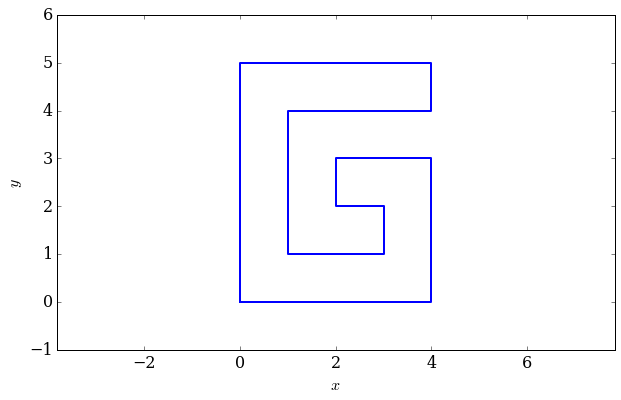

In [9]:
domain = numpy.array([[0.0, 0.0], [4.0, 0.0], [4.0, 3.0], [2.0, 3.0], [2.0, 2.0], [3.0, 2.0], [3.0, 1.0],
                      [1.0, 1.0], [1.0, 4.0], [4.0, 4.0], [4.0, 5.0], [0.0, 5.0], [0.0, 0.0]])
pyplot.figure(figsize=(10,6))
pyplot.plot(domain[:,0],domain[:,1], lw=2)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()

The temperature $T$ is fixed to be $1$ along the whole right boundary where $x=4$. On all other boundaries the normal derivative of the temperature vanishes. The heat source $f(x, y)$ is given by

$$
  f = \exp(-(x^2 + y^2)).
$$

### Tasks

1. Using the grid generation function below, and a finite element algorithm using linear elements as in the lab, compute and plot the solution of the heat equation with triangles of side-length $1/2$ and $1/16$.

#### Grid generation

In [10]:
def find_node_index_of_location(nodes, location):
    """
    Given all the nodes and a location (that should be the location of *a* node), return the index of that node.
    
    Parameters
    ----------
    
    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    location : array of float
        (2,) array containing the x, y coordinates of location
    """
    dist_to_location = numpy.linalg.norm(nodes - location, axis=1)
    return numpy.argmin(dist_to_location)
                

def generate_g_grid(side_length):
    """
    Generate a 2d triangulation of the letter G. All triangles have the same size (right triangles, 
    short length side_length)
    
    Parameters
    ----------
    
    side_length : float
        The length of each triangle. Should be 1/N for some integer N
    
    Returns
    -------
    
    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    IEN : array of int
        (Nelements, 3) array linking element number to node number
    ID : array of int
        (Nnodes,) array linking node number to equation number; value is -1 if node should not appear in global arrays.
    """
    x = numpy.arange(0, 4+0.5*side_length, side_length)
    y = numpy.arange(0, 5+0.5*side_length, side_length)
    X, Y = numpy.meshgrid(x,y)
    potential_nodes = numpy.zeros((X.size,2))
    potential_nodes[:,0] = X.ravel()
    potential_nodes[:,1] = Y.ravel()
    xp = potential_nodes[:,0]
    yp = potential_nodes[:,1]
    nodes_mask = numpy.logical_or(numpy.logical_and(xp>=2,numpy.logical_and(yp>=2,yp<=3)),
                                  numpy.logical_or(numpy.logical_and(xp>=3,yp<=3),
                                                   numpy.logical_or(xp<=1,
                                                                    numpy.logical_or(yp<=1, yp>=4))))
    nodes = potential_nodes[nodes_mask, :]
    ID = numpy.zeros(len(nodes), dtype=numpy.int)
    n_eq = 0
    for nID in range(len(nodes)):
        if numpy.allclose(nodes[nID,0], 4):
            ID[nID] = -1
        else:
            ID[nID] = n_eq
            n_eq += 1
    inv_side_length = int(1 / side_length)
    Nelements_per_block = inv_side_length**2
    Nelements = 2 * 14 * Nelements_per_block
    IEN = numpy.zeros((Nelements,3), dtype=numpy.int)
    block_corners = [[0,0], [1,0], [2,0], [3,0],
                     [0,1],               [3,1],
                     [0,2],        [2,2], [3,2],
                     [0,3],
                     [0,4], [1,4], [2,4], [3,4]]
    current_element = 0
    for block in block_corners:
        for i in range(inv_side_length):
            for j in range(inv_side_length):
                node_locations = numpy.zeros((4,2))
                for a in range(2):
                    for b in range(2):
                        node_locations[a+2*b,0] = block[0] + (i+a)*side_length
                        node_locations[a+2*b,1] = block[1] + (j+b)*side_length
                index_lo_l = find_node_index_of_location(nodes, node_locations[0,:])
                index_lo_r = find_node_index_of_location(nodes, node_locations[1,:])
                index_hi_l = find_node_index_of_location(nodes, node_locations[2,:])
                index_hi_r = find_node_index_of_location(nodes, node_locations[3,:])
                IEN[current_element, :] = [index_lo_l, index_lo_r, index_hi_l]
                current_element += 1
                IEN[current_element, :] = [index_lo_r, index_hi_r, index_hi_l]
                current_element += 1
    return nodes, IEN, ID

In [11]:
nodes, IEN, ID = generate_g_grid(1/2)

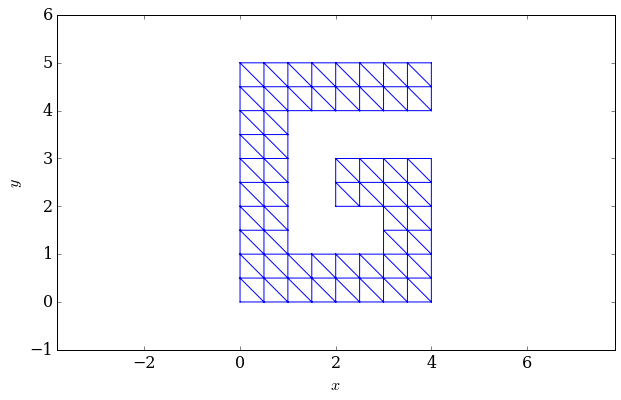

In [12]:
pyplot.figure(figsize=(10,6))
pyplot.triplot(nodes[:,0], nodes[:,1], triangles=IEN, lw=1)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()